# Austin Shelter Pet Outcomes <a name='top'></a>
*By Stephen FitzSimon*

## Key Takeaways From This Report

## Contents <a name='contents'></a>

*Note: the following hyperlinks will only work on local copies of this notebook; they will not function on GitHub!*

1. <a href='#introduction'>Introduction</a>
    1. <a href='#data_source'>Data Source</a>
2. <a href='#wrangle'>Wrangle The Data</a>
3. <a href='#exploring'>Exploring The Data</a>
4. <a href='#model'>Modeling</a>    

    
## Introduction <a name='introduction'></a>

<a href='https://www.austintexas.gov/austin-animal-center'>Austin Animal Center</a> provides animal services for the city of Austin, and unincorporated Travis county.  Since 2010 they have implemented a <a href='https://www.austintexas.gov/page/no-kill-plan'>'no-kill' strategy</a> to increase live outcomes for adoptions; this included community partnerships, community education, increased animal services and better data collection.  The goal of this project is to help understand how the Austin Animal Center can provide better services and outcomes for the animals and owners that they serve.  

This report is structered around the data science pipeline of 1. wrangle the data, 2. explore the data and 3. model the data.  Each sections includes key takeaways followed by a discussion that provides more in depth analysis; these are designed to provide all the necessary information to understand the project and arguments.  For more technical and analytical information, visualizations, calculations and code follow these two sections along with annotations and discussions.  If more detail is needed, reference the series of other notebooks as mentioned in the <a href='https://github.com/stephenfitzsimon/pet_adoption_project/blob/main/README.md'>readme file</a>. Hyperlinks are provided throughout to allow the user to navigate to relevant sections.

### Data Source <a name='data_source'></a>
The City of Austin provides an <a href='https://data.austintexas.gov/'>open data website</a> where the data for this project can be found.
- <a href= 'https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238'>Outcome data can be found here</a>
- <a href= 'https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm'>Intake data can be found here</a>
    
### Intro to the Target Variable
    
The model attempts to predict the outcomes for animals the first time they arrive at the shelter.  In the interest of simplicity, the various categories in the `outcome_type` column are aggregated into four categories. The model attempts to predict one of for outcomes as aggregated from the `outcome_type` column of the data:
1. Adoption
2. Transfer
3. Return to Owner (include Rto-Adopt category)
4. Other (includes the following: euthanised, died, disposal, missing, relocate, lost)

Many of the outcomes in the Other category were due to non-pet status (for example `A860153` is a bat and `A860288` is a grackle, both of which at intake were injured).  Of the euthanised/died animals, most were considered suffering/sick/injured.

<a href='#contents'>Back to Contents</a>

In [1]:
#data science modules used
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

#custom modules used
import wrangle
import explore

#global constants
PLT_SIZE = (15,6) #to format the visualizations

## Wrangle The Data <a name='wrangle'></a>

### Key Wrangle Takeaways
- Two tables of data are retrieved from the Austin <a href='https://data.austintexas.gov/'>open data website</a>
- The `Outcome` table contained 141170 records and 12 columns; the `Intake` table contained 141303 records and 12 columns
- Both tables were merged on the key `animal_id`
    - Duplicate records were dropped.  Many of the duplicate records were the same animal.
- Date columns were aggregated into `intake_date` and `outcome_date` and scaled to days
- Repeated columns were removed (example: `color` and `breed` were the same for both intake and outcome tables)
- `name` and `outcome_subtype` had null values inferred
- Remaining nulls were dropped
- Final table is 113944 rows and 17 columns

### Discusion

Data was retrieved from the Austin <a href='https://data.austintexas.gov/'>open data website</a> via the Socrata Open Data API (SODA) and the `sodapy` python module.  The <a href= 'https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238'>outcome data</a> contained 141170 records with 12 columns and the <a href= 'https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm'>intake data</a> contained 141303 records across 12 rows.  

Each row represents a single animal intake or outcome (a data dictionary can be found <a href='#appedix'>here</a>). The tables were merged on the `animal_id` column; however, duplicates were dropped for this project.  Many of the duplicate rows represented a single animal that had been returned to the shelter after a series of different outcomes--for example, record `A700407` indicates that the animal most likely escaped from the owner and was then returned to the owner multiple times over a period of 6 years (the animal is listed as `Stray` on the `Intake` table, and the the outcome is listed as `Returned to owner` / `Adoption` on the `Outcome` table).  While these records would be ideal to concatenate in a larger project, this project focuses on the adoptability of animals first entering the shelter.  It is most likely the case that the reduplicated records represent an animal that is difficult to adopt.

The date columns did not differ intra-table, and so were aggregated into `intake_date` and `outcome_date` and truncated to year-month-date form.  In addition, columns repeated on both tables were found to contain the same information, and these replicated columns were dropped.  The `outcome_subtype` and `name` columns had a significant number of null values; these were inferred to be `no name` and `no subtype`.  Several columns--`outcome_type`, `sex_at_outcome`, `age_at_outcome` and `sex_at_intake`--had null value; at most these represented 15 rows, and consequently were dropped. The `age_upon_intake` and `age_upon_outcome` both contained ages that were `String` data types of the forms `"x years"`, `"x months"` or `"x days"`. These were converted to a number of days; months were assumed to have $30.5$ days, and years were assumed to have $365.25$ days.  The final calculation was then rounded to `int` datatype.  As these ages are most likely estimation on the part of shelter staff, this is most likely enough accuracy.  Finally, as `date_of_birth` most likely was also an estimation, the column was dropped.

### Code

Code used in this section is contained in `wrangle.py` which programmatically retrieves and prepares the data.  It contains the following functions:
- `get_pet_data` : Checks if a csv file is present, and retrieves data from csv or url. A url query can be forced via `query_url=True`
- `download_data` : Returns the pet outcome and pet intake dataframes from the SODA API
- `make_date_columns` : Aggregates datetime columns into outcome and intake dates
- `null_fill_and_drop` : Fills nulls and drops null values. `name` columns nulls are inferred as no name and `outcome_subtype` is inferred as no subtype.  Remaining nulls are dropped
- `convert_age_column` : Converts age columns to days
- `rename_intake_cols` : Renames the columns from the intake table to make calling them easier
- `rename_intake` : Suffixes the column names of the intake table to distinguish from outcome columns after merge
- `join_tables` : Joins the intake and outake tables on the animal_id column
- `make_target_column` : Maps the various `outcome_types` to the target outcomes
- Flow control functions:
    - `make_pet_dataframe` : Flow control function to retrieve data and prepare it for exploration
    - `get_pet_dataframe` : Flow control function to get dataframe from url or .csv file and join both tables
    - `prepare_pet_dataframe` : Flow control function to prepare data

In [2]:
df = wrangle.make_pet_dataframe()
df.sample(5)

Returning saved csv files.


,animal_id,name,outcome_type,animal_type,sex_upon_outcome,breed,color,outcome_subtype,found_location,intake_type,intake_condition,sex_upon_intake,outcome_date,intake_date,target_outcome,age_at_outcome,age_at_intake
65995,A741128,Sugarcubes,Adoption,Cat,Neutered Male,Domestic Shorthair Mix,Blue Tabby,no subtype,6300 S Congress Ave in Austin (TX),Stray,Normal,Intact Male,2017-01-02,2016-12-28,Adoption,92,61
84341,A709262,*Peter,Adoption,Cat,Neutered Male,Siamese Mix,Seal Point,Foster,600 W William Cannon Dr in Austin (TX),Stray,Normal,Intact Male,2015-09-12,2015-08-06,Adoption,61,28
29522,A801791,no name,Disposal,Other,Unknown,Bat,Brown/Brown,no subtype,900 Barton Springs in Austin (TX),Wildlife,Sick,Unknown,2019-08-10,2019-08-09,Other,730,730
86976,A707441,no name,Transfer,Dog,Spayed Female,Great Pyrenees,White,Partner,15128 Mandarin Xing in Travis (TX),Stray,Normal,Intact Female,2015-07-19,2015-07-13,Transfer,365,365
69456,A735460,*Majic,Transfer,Cat,Neutered Male,Domestic Shorthair Mix,Black/White,Partner,1004 Ellingson in Austin (TX),Owner Surrender,Normal,Neutered Male,2016-09-28,2016-09-24,Transfer,1096,1096


<a href='#contents'>Backt to Contents</a>

## Exploring The Data <a name='exploring'></a>

### Key Explore Takeaways
- Overall adoption rate is $0.43$; adoption and transfer represent the majority of outcomes ($0.76$ of all outcomes)
- As the majority of animals in the data are cats or dogs ($0.92$ of the data), the majority of the exploration focuses on these two animal types
    - The adoption rate among cats and dogs is $0.45$
- Most animals are brought in as strays ($0.72$) and are in normal condition ($0.84$)
- The average age of adoption of animals is 183 days old
- Intake and adoption rates peak in May-June, and is largely driven by seasonality of cat intakes
- The average length of stay at the shelter is 26 days for dogs and 40 for cats.


### Section Contents

1. <a href='#split'>Splitting data into Train, Validate and Test </a>
1. <a href='#prop_outcome'>What are typical animal outcomes?</a>
2. <a href='#intake_condition'>What is the intake condition of adopted animals?</a>
3. <a href='#age_adoption'>Among cats and dogs, are they likely to be adopted at a certain age? </a>
5. <a href='#date_intake'>What is the relationship between date of intake and adoption status? </a>
6. <a href='#breed_color'>Are certain breeds/colors of dogs and cats more popular as adoptions? </a>
7. <a href='#avg_stay'>What is the length of stay of animals?</a>

#### How subsections are structured

The following subsections are titled by a question, which is followed by a discussion.  Following, visualization and numeric data are presented; in addition, hypothesis tests are presented if applicable.

### Discussion

The overall adoption rate in the data is $0.43$.  However, the majority of the data ($0.92$) represents cats and dogs which have a higher adoption rate of $0.45$.  This would be expected as, based off of experience, the majority of people who visit a shelter are looking to adopt a cat or a dog.  In addition, $0.67$ of the non cat or dog animals were categorized as wildlife (the majority of which were bats), and are not adoptable.  This is also shown by the fact that dogs and cats represent $0.92$ of all adoptions and $0.96$ of all transfers.

In terms of animal intake, the most common intake type is stray, representing $0.72$ of all intakes.  The majority of these animals are classified as 'normal' condition, representing $0.84$ of all intakes.  Stray intakes represent $0.44$ of all adotions.  However, $0.58$ of all adoptions are owner surrenders; this might be surprising, as it might be expected that owners surrender problem pets, but this might not be the case. 

Younger animals are more adoptable; most animals are adotped at 183 days old.  There was not a major difference between animal types. Intakes for all animals peak in May-June, with adoptions peaking at the same time.  This is largely driven by cats; cat intakes and adoptions peak in the summer, whereas dog intake and adoption is relatively constant throughout the year. 

Happily, owners seem to not be looking for a particular breed/color to adopt. Among cats, the colors match up nearly perfectly; the one exception seems that black cats are slightly more difficult to adopt.  In terms of dog breed, Labrador Retrievers are easier to adopt; even though there are mainly Pit Bull Mixes that are more likely to be received at intake (there is a $-0.015$ difference between the numbers, every other column has a difference of less than $\pm 0.01$).

The average length of stay of adopted animals is 32 days; however, dogs are adopted about 2 weeks earlier than cats.

### Code

All hypothesis testing is done at a 95% confidence level ($α = 0.05$).

The following code is used in this section:
- From the `wrangle.py` module
    - `split_data(df, target_col, cat_cols)` : Gets the proportion of each value in `target_col` for `cat_cols` passed and each subcategory in the cat_cols column.  Essentially performs a `value_counts(normalize=True)` on each category for the `target_col` values
- From the `explore.py` module
    - `chi_square_test` : performs a  $χ^2$ test
    - `t_test_lesser` : performs a one sample t-test
    - `get_top_ten_compare` : compares intake and adoption rates bby breed and color
    - `mann_whitney` : performs a Mann Whitney U test
    
<a href='#contents'>Back to Contents</a>

### Splitting data into Train, Validate and Test <a name='split'></a>

Data is split into train, validate and test subsets.  All exploration is done on the train set; validate and test sets are reserved to evaluate machine learning models.

In [3]:
train, validate, test = wrangle.split_data(df) #split the data

In [4]:
train.shape, validate.shape, test.shape #show the size of the subsets

((63808, 17), (27347, 17), (22789, 17))

Take a look at a sample of the train data:

In [5]:
train.sample(5)

,animal_id,name,outcome_type,animal_type,sex_upon_outcome,breed,color,outcome_subtype,found_location,intake_type,intake_condition,sex_upon_intake,outcome_date,intake_date,target_outcome,age_at_outcome,age_at_intake
53271,A757775,*Nero,Adoption,Dog,Neutered Male,Pit Bull Mix,Tan/White,no subtype,18312 Cameron Rd in Manor (TX),Stray,Normal,Intact Male,2017-11-24,2017-09-06,Adoption,730,730
53279,A558639,Jesebel,Return to Owner,Cat,Spayed Female,Domestic Shorthair Mix,Calico,no subtype,6301 West Slaughter Lane in Austin (TX),Stray,Normal,Spayed Female,2017-11-24,2017-11-22,Other,3287,3287
95332,A691586,*Cassidy,Transfer,Dog,Spayed Female,Pit Bull Mix,Tan/White,Partner,6807 Pondsdale Ln in Austin (TX),Stray,Normal,Intact Female,2014-12-24,2014-11-06,Transfer,365,365
111513,A668730,Opal,Adoption,Cat,Spayed Female,Domestic Shorthair Mix,Blue Tabby/White,no subtype,Tillery And Lyons in Austin (TX),Stray,Normal,Intact Female,2013-12-12,2013-12-08,Adoption,61,61
45024,A776526,Bonnie,Transfer,Dog,Intact Female,Border Collie Mix,White/Black,Partner,Austin (TX),Public Assist,Normal,Intact Female,2018-07-24,2018-07-15,Transfer,365,365


<a href='#contents'>Back to Contents</a>

### What are typical animal outcomes? <a name='prop_outcome'></a>

#### Key Takeaways
- Adoption ($0.43$) and transfer ($0.33$) are the most common outcomes for all animals
- Cat and dogs are most likely to be adopted or transferred
- Cats and dogs represent $0.98$ of adoptions and $0.96$ of transfers.
- The adoption rate among cats and dogs ($0.45$) is higher than the general adoption rate.

#### What are the most common outcomes overall?

The most common overall outcome for all animals is adoption, followed by transer.  These represent $0.76$ of all outcomes.

Text(0.5, 0, 'Animal Outcome')

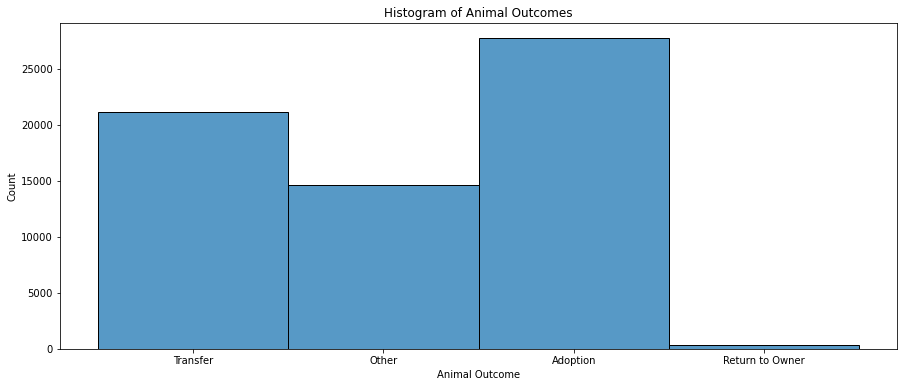

In [6]:
#plot the count of the target outcomes
plt.figure(figsize=PLT_SIZE)
sns.histplot(data=train, x='target_outcome')
#set strings
plt.title('Histogram of Animal Outcomes')
plt.xlabel('Animal Outcome')

In [7]:
# same data but proportional
train.target_outcome.value_counts(normalize=True)

Adoption           0.434710
Transfer           0.331322
Other              0.229297
Return to Owner    0.004670
Name: target_outcome, dtype: float64

#### Are some outcomes determined by animal type?

Cats and dogs represent a large proportion of adopted and transfered animals.  Cats appear more likely to be transfered- I suspect that this is because cat's are likely to be part of the SCRP (Stray Cat Return Program) and the SNR (Spay Neuter Release) program.

Text(0.5, 0, 'Animal Outcome')

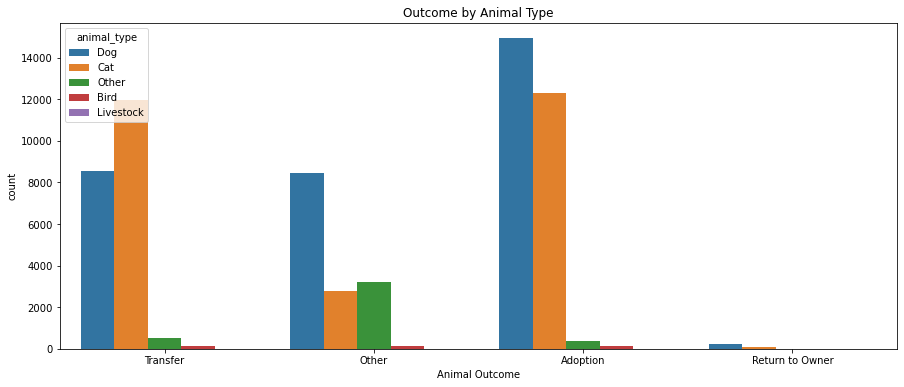

In [8]:
#plot the target outcome hued by animal type
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x='target_outcome', hue='animal_type')
#set strings
plt.title('Outcome by Animal Type')
plt.xlabel('Animal Outcome')

In [9]:
#same data but numeric
train.groupby('animal_type').target_outcome.value_counts(normalize=True)

animal_type  target_outcome 
Bird         Other              0.352632
             Adoption           0.342105
             Transfer           0.305263
Cat          Adoption           0.453473
             Transfer           0.440643
             Other              0.102824
             Return to Owner    0.003060
Dog          Adoption           0.464567
             Transfer           0.265182
             Other              0.263628
             Return to Owner    0.006623
Livestock    Adoption           0.444444
             Transfer           0.333333
             Other              0.222222
Other        Other              0.780464
             Transfer           0.131044
             Adoption           0.088008
             Return to Owner    0.000484
Name: target_outcome, dtype: float64

#### How much of each outcome do cats and dogs represent?

Dogs and cats represent $0.92$ of the data. Unsurprisingly then, they also represent $0.98$ of adoptions and $0.96$ of transfers.

Text(0.5, 0, 'Animal Outcome')

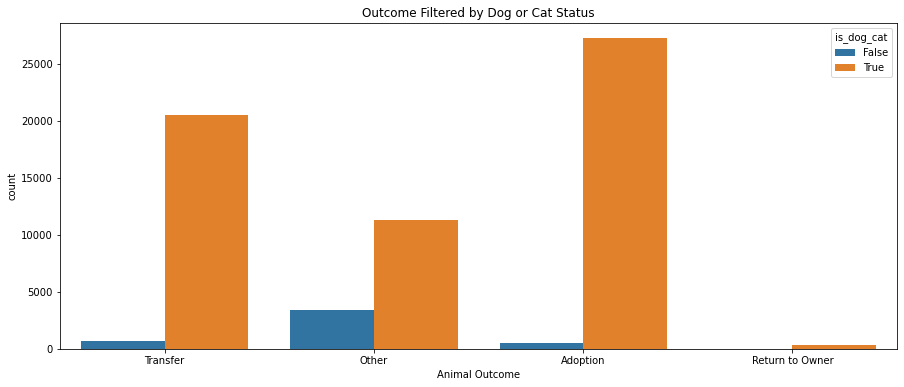

In [10]:
#make a boolean column
train['is_dog_cat'] = train['animal_type'].isin(['Cat', 'Dog'])
#plot the target outcome hued by is_dog_cat
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x='target_outcome', hue='is_dog_cat')
#set strings
plt.title('Outcome Filtered by Dog or Cat Status')
plt.xlabel('Animal Outcome')

In [11]:
#same data but numeric
train.groupby('target_outcome').is_dog_cat.value_counts(normalize=True)

target_outcome   is_dog_cat
Adoption         True          0.982046
                 False         0.017954
Other            True          0.770077
                 False         0.229923
Return to Owner  True          0.993289
                 False         0.006711
Transfer         True          0.968734
                 False         0.031266
Name: is_dog_cat, dtype: float64

In [12]:
#how much of the data is represented by cats and dogs
train.is_dog_cat.mean()

0.9290841273821464

#### What is the rate of adoption among cats and dogs?

Adoption rate among only cats and dogs is $0.46$, and the transfer rate is $0.35$. 

Text(0.5, 0, 'Animal Outcome')

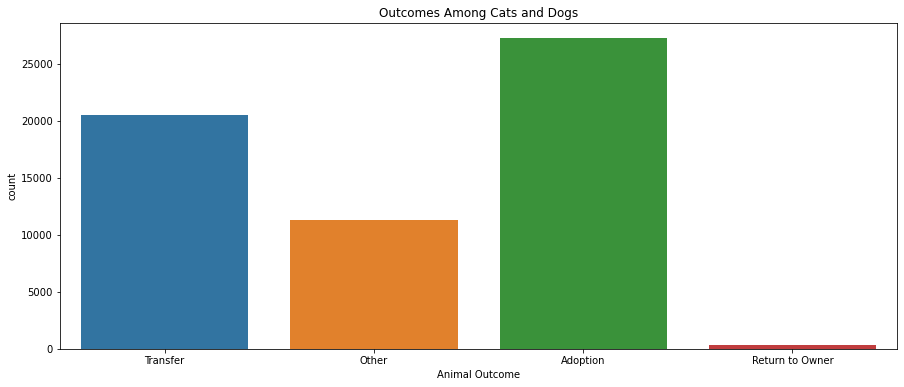

In [13]:
#plot the target outcome hued by is_dog_cat
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train[train.is_dog_cat], x='target_outcome')
#set strings
plt.title('Outcomes Among Cats and Dogs')
plt.xlabel('Animal Outcome')

In [14]:
#same data but numeric
train[train.is_dog_cat].target_outcome.value_counts(normalize=True)

Adoption           0.459491
Transfer           0.345462
Other              0.190054
Return to Owner    0.004993
Name: target_outcome, dtype: float64

#### Hypothesis Testing

Perform the following $χ^2$ tests:

1. Are cats and dogs more likely to get adopted?

$H_0$ : Animal type of cat or dog is independent of outcome 'Adoption'

$H_a$ : Animal type of cat or dog is not independent of outcome 'Adoption'

In [15]:
explore.chi_square_test(train['is_dog_cat'], train['target_outcome'])

,χ^2,p,reject_null
0,7318.418053,0.0,True


The null hypothesis is likly wrong.

<a href='#contents'>Back to Contents</a>

### What are the animals who get adopted like at intake? <a name='intake_condition'></a>

#### Key Takeaways
- $0.72$ of intake types are strays, that majority of which are cats and dogs
- Most ($0.84$) are in normal condition.

#### What are the intake types of animals in general?

The majority of animals at intake are strays with a proportion of strays at $0.72$, followed by owner surrender.

Text(0.5, 0, 'Intake type')

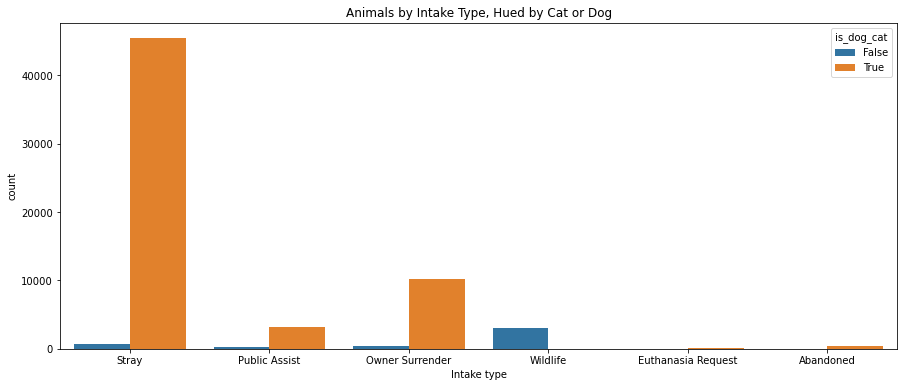

In [16]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x='intake_type', hue='is_dog_cat')
#set strings
plt.title('Animals by Intake Type, Hued by Cat or Dog')
plt.xlabel('Intake type')

In [17]:
train['intake_type'].value_counts(normalize=True)

Stray                 0.723624
Owner Surrender       0.167173
Public Assist         0.052987
Wildlife              0.047815
Abandoned             0.006394
Euthanasia Request    0.002006
Name: intake_type, dtype: float64

#### What is the intake condition of the animals?

The majority of animals ($0.84$) are in normal condition.

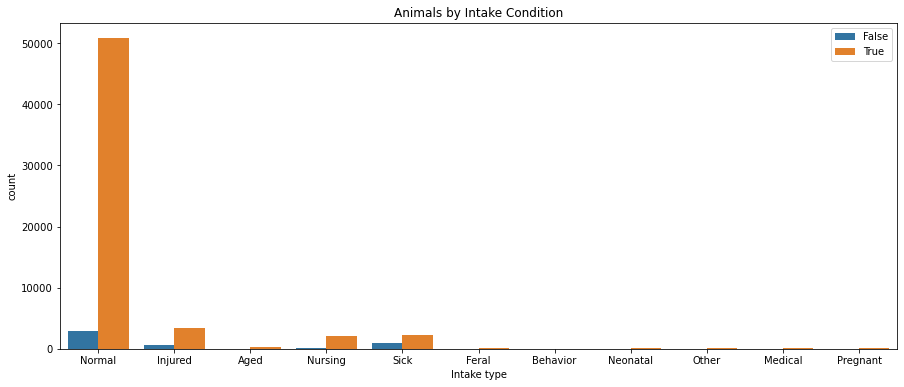

In [18]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x='intake_condition', hue='is_dog_cat')
#set strings
plt.title('Animals by Intake Condition')
plt.xlabel('Intake type')
plt.legend(loc='upper right')

In [19]:
#same information but numeric
train.intake_condition.value_counts(normalize=True)

Normal      0.842073
Injured     0.062155
Sick        0.050260
Nursing     0.033444
Aged        0.003432
Neonatal    0.003369
Other       0.002069
Medical     0.001081
Feral       0.001034
Pregnant    0.000784
Behavior    0.000298
Name: intake_condition, dtype: float64

<a href='#contents'>Back to Contents</a>

### Are some intakes types leading to certain outcomes?

Strays are owner surrenders are most likely to have transfer or adoption outcome.  $0.44$ of adoptions are of strays, and $0.36$ are transferred. Owner surrenders are also likely to be adopted or transferred, at rates of $0.58$ and $0.32$ respectively.

Text(0.5, 0, 'Intake Type')

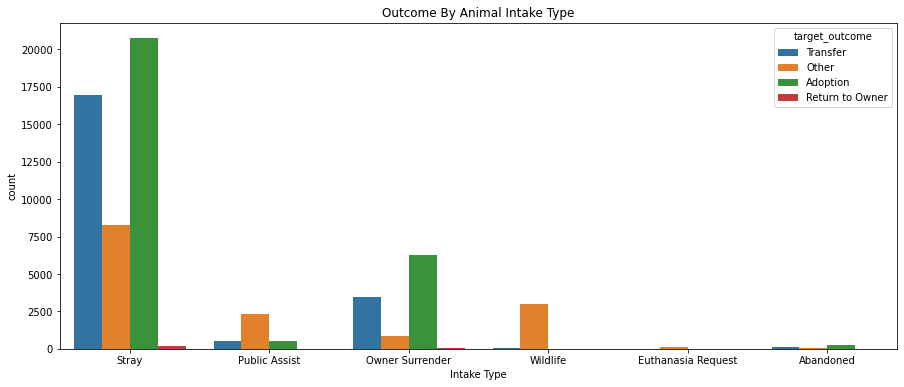

In [20]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x='intake_type', hue='target_outcome')
#set strings
plt.title('Outcome By Animal Intake Type')
plt.xlabel('Intake Type')

In [21]:
#same data but numeric
train.groupby('intake_type').target_outcome.value_counts(normalize=True)

intake_type         target_outcome 
Abandoned           Adoption           0.551471
                    Transfer           0.328431
                    Other              0.102941
                    Return to Owner    0.017157
Euthanasia Request  Other              0.835938
                    Transfer           0.125000
                    Adoption           0.039062
Owner Surrender     Adoption           0.585919
                    Transfer           0.326427
                    Other              0.079779
                    Return to Owner    0.007875
Public Assist       Other              0.690920
                    Transfer           0.155871
                    Adoption           0.147294
                    Return to Owner    0.005915
Stray               Adoption           0.449505
                    Transfer           0.366816
                    Other              0.179629
                    Return to Owner    0.004050
Wildlife            Other              0.983612
    

#### Hypothesis testing

Perform the following $χ^2$ tests:

1. Are strays more likely to be adopted?

$H_0$ : Intake as a stray is independent of adoption.

$H_a$ : Intake as a stray is not independent of adoption.

In [22]:
explore.chi_square_test(train['intake_type']=='Stray', train['target_outcome']=='Adoption')

,χ^2,p,reject_null
0,148.592018,3.521442e-34,True


The null hypothesis is likely false.

2. Are Owner surrenders more likely to be adopted?

$H_0$ : Intake as a owner surrender is independent of adoption.

$H_a$ : Intake as a owner surrender is not independent of adoption.

In [23]:
explore.chi_square_test(train['intake_type']=='Owner Surrender', train['target_outcome']=='Adoption')

,χ^2,p,reject_null
0,1190.972053,5.588949e-261,True


The null hypothesis is likely to be false.

<a href='#contents'>Back to Contents</a>

### Among cats and dogs, are they likely to be adopted at a certain age? <a name='age_adoption'></a>

Dogs and cats are adopted at a younger age than other outcomes.  The median animal is adopted at 183 days old; moreover, $0.60$ of animals are adopted under a year old.  Cats and dogs that are adopted are also younger at intake; the median intake age of animals that are adopted is 152 days.  It is worth noting that there are some outliers that drive the mean age in days to $>500$ days.

#### Are cats and dogs adopted at a certain age?

Text(0.5, 0, 'Intake Type')

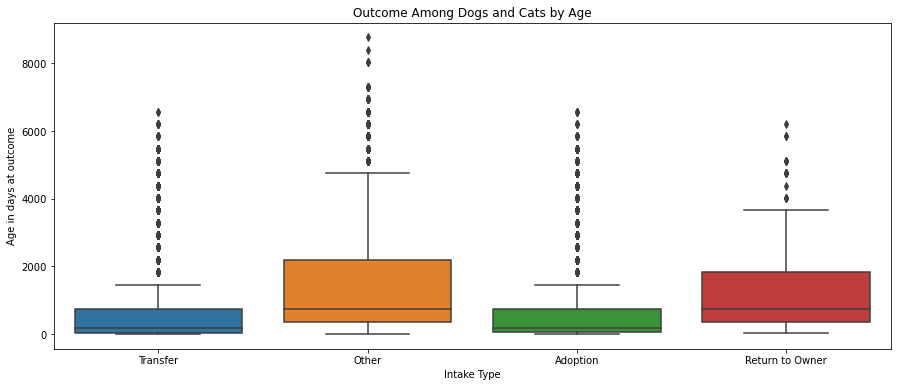

In [24]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.boxplot(data=train[train['is_dog_cat']], x='target_outcome', y='age_at_outcome')
#set strings
plt.title('Outcome Among Dogs and Cats by Age')
plt.ylabel('Age in days at outcome')
plt.xlabel('Intake Type')

In [25]:
#same data numerically
train[train['is_dog_cat']].groupby('target_outcome').age_at_outcome.describe()

,count,mean,std,min,25%,50%,75%,max
target_outcome,,,,,,,,
Adoption,27240.0,526.742841,836.042481,0.0,61.0,183.0,730.0,6574.0
Other,11267.0,1432.057069,1463.262961,0.0,365.0,730.0,2192.0,8766.0
Return to Owner,296.0,1292.567568,1279.401105,30.0,365.0,730.0,1826.0,6209.0
Transfer,20480.0,559.130664,911.214748,0.0,30.0,183.0,730.0,6574.0


In [26]:
#calculate the quantile at 0.6
train[train['is_dog_cat']].groupby('target_outcome').age_at_outcome.quantile(0.6)

target_outcome
Adoption            365.0
Other              1096.0
Return to Owner    1096.0
Transfer            365.0
Name: age_at_outcome, dtype: float64

#### Are cats and dogs intaked at a certain age?

Text(0.5, 0, 'Intake Type')

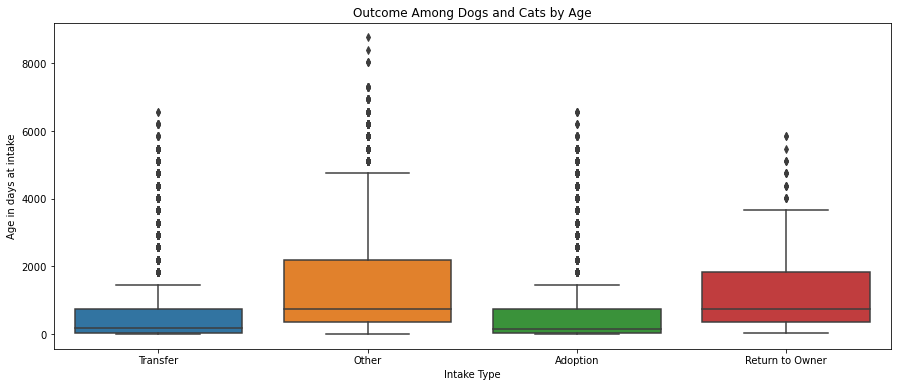

In [27]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.boxplot(data=train[train['is_dog_cat']], x='target_outcome', y='age_at_intake')
#set strings
plt.title('Outcome Among Dogs and Cats by Age')
plt.ylabel('Age in days at intake')
plt.xlabel('Intake Type')

In [28]:
#same data numerically
train[train['is_dog_cat']].groupby('target_outcome').age_at_intake.describe()

,count,mean,std,min,25%,50%,75%,max
target_outcome,,,,,,,,
Adoption,27240.0,501.654809,830.600644,0.0,30.0,152.0,730.0,6574.0
Other,11267.0,1423.723440,1462.085247,0.0,365.0,730.0,2192.0,8766.0
Return to Owner,296.0,1252.550676,1246.695213,28.0,365.0,730.0,1826.0,5844.0
Transfer,20480.0,551.413232,906.718364,0.0,28.0,183.0,730.0,6574.0


#### Hypothesis Testing

Perform a one sample t-test on the following questions:

1. Do adoptions among cats and dogs happen at a younger age than non-adoptions?

$H_0$ : The mean adoption age of a dog or cat is equal or higher than the mean age of a non-adopted dog or cat.

$H_a$ : The mean adoption age of a dog or cat is lesser than the mean age of a non-adopted dog or cat.

In [29]:
explore.t_test_lesser(train[train['is_dog_cat']], column_cat='target_outcome', subcat_val='Adoption', column_cont='age_at_outcome')

,category_name,category_value,t-stat,p-value,reject_null
0,target_outcome,Adoption,-68.325046,0.0,True


The null hypothesis is likely false.

2. Are cats and dogs intakes ending in adoption at a younger age than non-adoption outcomes?

$H_0$ : The mean age at intake among adopted cats and dogs is equal to or higher than non-adopted dogs or cats.

$H_a$ : The mean age at intake among adopted cats and dogs is lesser than non-adopted dogs or cats.

In [30]:
explore.t_test_lesser(train[train['is_dog_cat']], column_cat='target_outcome', subcat_val='Adoption', column_cont='age_at_intake')

,category_name,category_value,t-stat,p-value,reject_null
0,target_outcome,Adoption,-72.121994,0.0,True


The null hypothesis is liekly false.

<a href='#contents'>Back to contents</a>

### What is the relationship between date of intake and adoption status? <a name='date_intake'></a>

Intakes are higher in May and June and lower in December to February.  Adoption peak just after the intakes peak; but adoption also remain more constant in the winter.  These peaks are driven by cat population, and it also drives adoption rates among cats which increase about a month after cat intakes peak.  In contrast, dog intakes and adoptions remain relatively constant throughout the year.

#### Are there certain months with higher intake rates?

Intakes peak in May and June.

Text(0.5, 0, 'Intake Month')

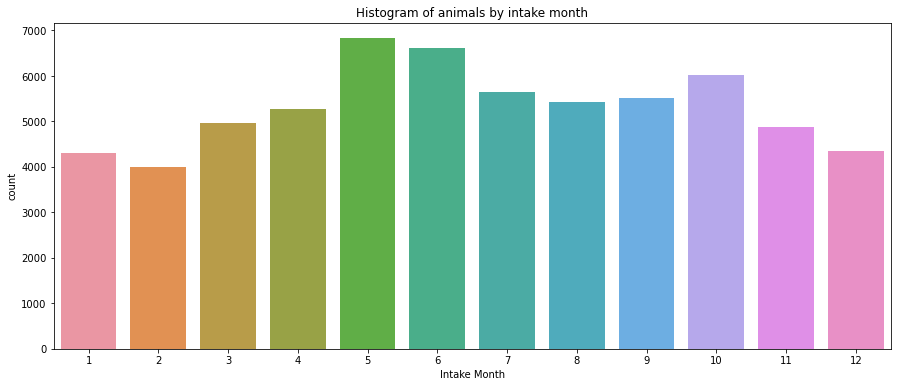

In [31]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x=train.intake_date.dt.month)
#set strings
plt.title('Histogram of animals by intake month')
plt.xlabel('Intake Month')

#### Is there a particular animal type that is driving intakes during peak months?

Cats appear to be driving the peak intake months; whereas dogs remain relatively constant throughout the year.

Text(0.5, 0, 'Intake Month')

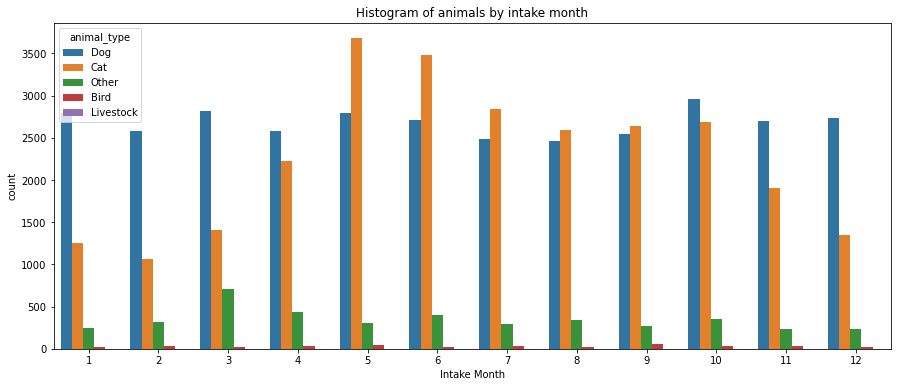

In [32]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x=train.intake_date.dt.month, hue=train.animal_type)
#set strings
plt.title('Histogram of animals by intake month')
plt.xlabel('Intake Month')

#### Are adoption higher in some months?

Adoption peak just after intake peak.  Again, this is driven largely by cats, as dog adoptions remain relatively constant throughout the year.

Text(0.5, 0, 'Outcome Month')

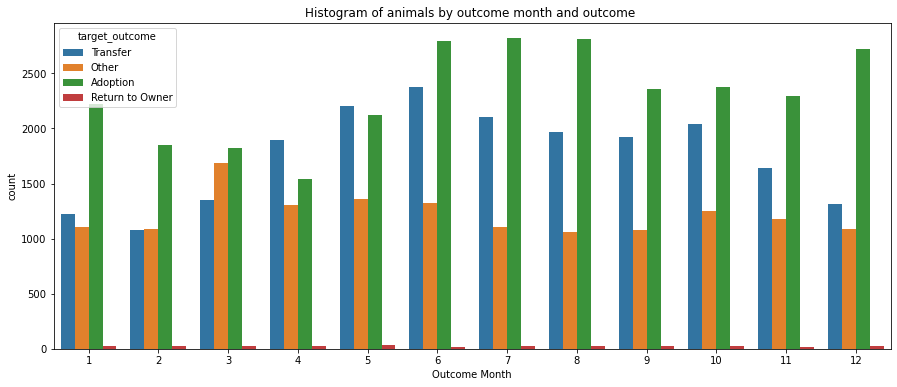

In [33]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x=train.outcome_date.dt.month, hue='target_outcome')
#set strings
plt.title('Histogram of animals by outcome month and outcome ')
plt.xlabel('Outcome Month')

Text(0.5, 0, 'Outcome Month')

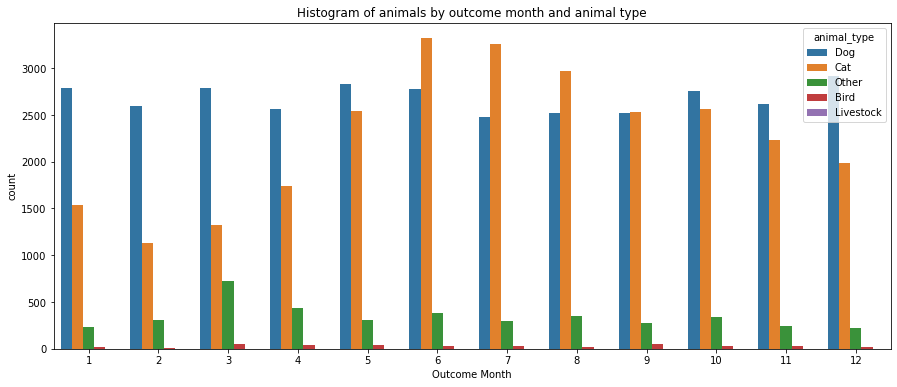

In [34]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x=train.outcome_date.dt.month, hue='animal_type')
#set strings
plt.title('Histogram of animals by outcome month and animal type')
plt.xlabel('Outcome Month')

<a href='#contents'>Back to Contents</a>

### Are certain breeds/colors of dogs and cats more popular as adoptions? <a name='breed_color'></a>

In order to see if there is a mismatch between the animals at intake, look at the top ten colors/breeds that are adopted and the top ten at intake.  Because cat breeds are assumed to be less important among adopters, `color` is used as a proxy for testing breed (noting that the majority of cats are catagorized as "Domestic X-hair"). If the percentage at intake is similar to the percantage at adoption, it would indicate that there is a mismatch between the type of animals at intake, and the type of animals that perspective owners are looking to adopt.

Happily, owners seem to not be looking for a particular breed/color to adopt. Among cats, the colors match up nearly perfectly; the one exception seems that black cats are slightly more difficult to adopt.  In terms of dog breed, Labrador Retrievers are easier to adopt; even though there are mainly Pit Bull Mixes that are more likely to be received at intake (there is a $-0.015$ difference between the numbers, every other column has a difference of less than $\pm 0.01$).

#### Is there a mismatch between the top ten cat colors at intake and top ten cat colors among adoptions?

In [35]:
explore.get_top_ten_compare(train, 'Adoption', 'Cat', 'color').sort_values('Most common color at Adoption', ascending=False).iloc[0:10,:]

,Most common color at Adoption,Most common color at intake,difference
Brown Tabby,0.153089,0.153296,-0.000207
Black,0.126829,0.130844,-0.004014
Black/White,0.091301,0.093533,-0.002233
Brown Tabby/White,0.077967,0.076279,0.001688
Orange Tabby,0.072683,0.075063,-0.002380
Tortie,0.048862,0.047117,0.001745
Calico,0.046423,0.043946,0.002476
Orange Tabby/White,0.041626,0.036499,0.005127
Blue Tabby,0.039187,0.038859,0.000328
Blue,0.037724,0.038564,-0.000840


#### Is there a mismatch between the top ten dog breeds at intake and top ten dog breeds among adoptions?

In [36]:
explore.get_top_ten_compare(train, 'Adoption', 'Dog', 'breed').sort_values('Most common breed at Adoption', ascending=False).iloc[0:10,:]

,Most common breed at Adoption,Most common breed at intake,difference
Labrador Retriever Mix,0.104351,0.094966,0.009385
Chihuahua Shorthair Mix,0.091432,0.092167,-0.000735
Pit Bull Mix,0.081058,0.095899,-0.014841
German Shepherd Mix,0.048461,0.042818,0.005642
Australian Cattle Dog Mix,0.028447,0.022886,0.005561
Pit Bull,0.026573,0.026524,0.000049
Chihuahua Shorthair,0.020281,0.021176,-0.000895
Labrador Retriever,0.019344,0.018440,0.000904
German Shepherd,0.017470,0.015734,0.001736
Dachshund Mix,0.015663,0.015206,0.000457


<a href='#contents'>Back to Contents</a>

### What is the length of stay of animals? <a name='avg_stay'></a>

Most animals that are not adopted stay only for the day.  The average animal stay ending in adoption is 32 days.  Cats tend to stay about two weeks longer than dogs.

In [37]:
#make a column containing the information
train['length_of_stay'] = train.outcome_date-train.intake_date

Text(0.5, 1.0, 'Length of Stay in Days by Outcome Type')

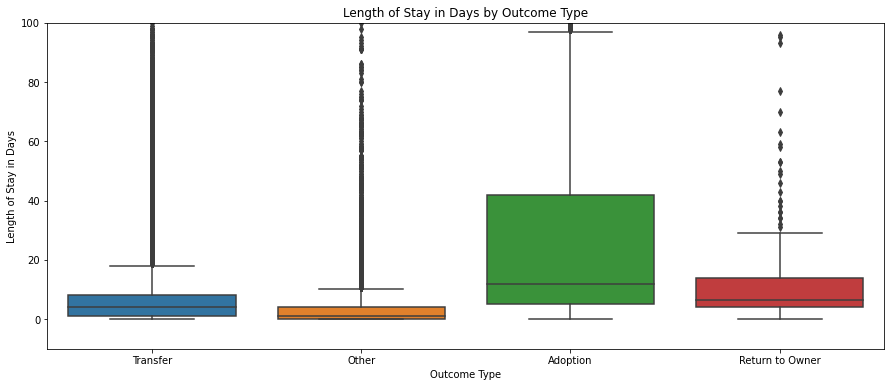

In [38]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.boxplot(data=train, x='target_outcome', y=train.length_of_stay.dt.days)
#zoom into the data so it's visible
plt.ylim(-10, 100)
#label the plot
plt.xlabel('Outcome Type')
plt.ylabel('Length of Stay in Days')
plt.title('Length of Stay in Days by Outcome Type')

In [39]:
#same data but numerically
train.groupby('target_outcome').length_of_stay.describe()

,count,mean,std,min,25%,50%,75%,max
target_outcome,,,,,,,,
Adoption,27738,32 days 20:11:12.809863725,57 days 12:40:19.028953926,0 days 00:00:00,5 days 00:00:00,12 days 00:00:00,42 days 00:00:00,1522 days 00:00:00
Other,14631,4 days 04:29:46.344063973,16 days 04:38:57.137055014,0 days 00:00:00,0 days 00:00:00,1 days 00:00:00,4 days 00:00:00,617 days 00:00:00
Return to Owner,298,15 days 07:05:14.093959731,26 days 21:52:44.681384582,0 days 00:00:00,4 days 00:00:00,6 days 12:00:00,14 days 00:00:00,207 days 00:00:00
Transfer,21141,9 days 01:05:27.458492975,21 days 10:04:52.447665543,0 days 00:00:00,1 days 00:00:00,4 days 00:00:00,8 days 00:00:00,837 days 00:00:00


#### Is the length of stay among adopted animals different by animal type?

Text(0.5, 1.0, 'Length of Stay in Days by Cat vs. Dog')

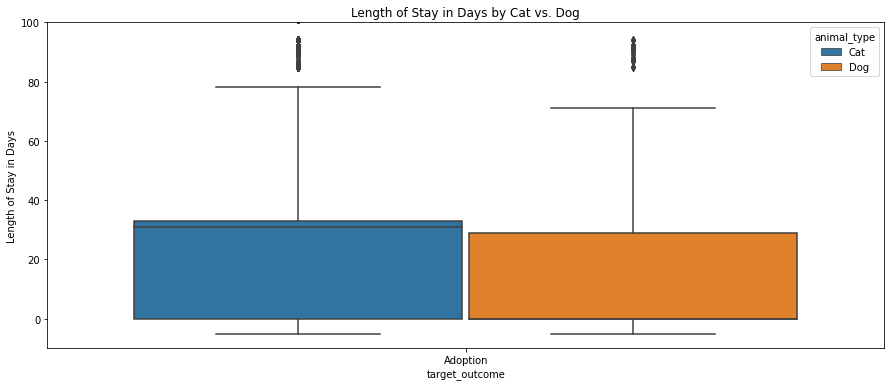

In [40]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.boxplot(data=train[(train.target_outcome=='Adoption')&(train.animal_type.isin(['Cat', 'Dog']))], x='target_outcome', y=train.age_at_outcome-train.age_at_intake, hue='animal_type')
#zoom into the data so it's visible
plt.ylim(-10, 100)
#label the plot
plt.ylabel('Length of Stay in Days')
plt.title('Length of Stay in Days by Cat vs. Dog')

In [41]:
train[(train.target_outcome=='Adoption')&(train.animal_type.isin(['Cat', 'Dog']))].groupby('animal_type').length_of_stay.describe()

,count,mean,std,min,25%,50%,75%,max
animal_type,,,,,,,,
Cat,12300,40 days 10:55:57.658536585,52 days 13:03:03.867312564,0 days 00:00:00,8 days 00:00:00,28 days 00:00:00,55 days 00:00:00,1102 days 00:00:00
Dog,14940,26 days 21:51:02.168674699,61 days 05:29:53.249751471,0 days 00:00:00,4 days 00:00:00,7 days 00:00:00,24 days 00:00:00,1522 days 00:00:00


#### Hypothesis testing

1. Is the average length of stay of a dog shorter than a cat's average length of stay?

$H_0$ : The mean length of stay of a dog is is equal to or greater than the mean length of stay of a cat

$H_a$ : The mean length of stay of a dog is is less than the mean length of stay of a cat

In [42]:
explore.mann_whitney(train[train['animal_type']=='Dog'].length_of_stay, train[train['animal_type']=='Cat'].length_of_stay)

,U-Stat,p-value,reject_null
0,411202057.5,1.021590e-33,True


The null hypothesis is likely false.

<a href='#contents'>Back to Contents</a>

## Modeling <a name='model'></a>

### Key Takeaways
- Only modeling for dogs and cats, as these represent the majority of the data
- Classification models are used
- Calculated column representing length of stay is used in modeling, but is cast to `int`
- `intake_date` is transformed into an `int` representing the numeric representation of the month
- Baseline accuracy is $0.43$

### Discussion

Models are evaluated on their accuracy, and how well they surpass the baseline accuracy of $0.43$.  The column `intake_date` is made into a column representing the month of intake.  In order to handle the large number of values in `color` and `breed`, a series of boolean columns of the form `is_{color}` and `is_{breed}` are calculated for modeling; these mainly cover all colors and breeds that are present in at least 200 rows of the data. Note that animal `A844562` is categorized as a Dog which has `intake_type = 'Wildlife'`; this causes an extra column in the dataframe where this animal is encoded--therefore the row is dropped.

The following columns are not used in modeling, with discussion where relevant:
- `outcome_date` : data repeated essentialy from `intake_date` see discussion in <a href='#explore'>Explore</a> section
- `name`
- `sex_upon_outcome` and `sex_upon_intake`
- `outcome_type` and `outcome_subtype`
- `found_location`

<a href='#contents'>Backt to Contents</a>

### Prepare data for modeling and make a baseline model

- Data is prepared
- Baseline model based on train
- Data is encoded and split

#### Renew data and splits to make a clean dataframe

In [43]:
df = wrangle.make_pet_dataframe()
train, validate, test = wrangle.split_data(df) 

Returning saved csv files.


#### Baseline Model

Use the most common outcome as the baseline prediction.  Baseline accuracy is $0.43$, and represents a prediction of adoption which is the most common outcome among animals.

In [44]:
compare_models = []
#make a baseline model
#most pets are adopted. baseline model is pet gets adopted
baseline_prediction = train.target_outcome.value_counts().idxmax() #get most common value
baseline_model = pd.Series([baseline_prediction for x in range(train.shape[0])]) #make a dataframe with the predictions

#save accuracy in a variable and product e classification report
baseline_accuracy = metrics.classification_report(train.target_outcome, baseline_model, zero_division=True, output_dict=True)['accuracy']
pd.DataFrame(metrics.classification_report(train.target_outcome, baseline_model, zero_division=True, output_dict=True)).T

,precision,recall,f1-score,support
Adoption,0.434710,1.00000,0.605990,27738.00000
Other,1.000000,0.00000,0.000000,14631.00000
Return to Owner,1.000000,0.00000,0.000000,298.00000
Transfer,1.000000,0.00000,0.000000,21141.00000
accuracy,0.434710,0.43471,0.434710,0.43471
macro avg,0.858678,0.25000,0.151498,63808.00000
weighted avg,0.754263,0.43471,0.263430,63808.00000


In [45]:
baseline_accuracy

0.4347103811434303

### Make X and y sets

X and y sets are made to prepare for modeling.

This section calls `make_model_sets` which does the following:
- `make_feature_columns_and_filter` : filters the set to only dogs and cats, makes breed and color columns as stated above, calculates length of of stay, and makes intake month column
- `drop_columns_for_model` : drops unnecessary 

In [46]:
X_train, y_train = wrangle.make_model_sets(train)

X_validate, y_validate = wrangle.make_model_sets(validate)

X_test, y_test = wrangle.make_model_sets(test)

Check to make sure they have equal columns

In [47]:
X_train.shape, X_validate.shape, X_test.shape

((59282, 105), (25380, 105), (21180, 105))